<a href="https://colab.research.google.com/github/GusevMihail/seamless_textute_generator/blob/master/sandbox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U albumentations

In [1]:
import os.path
import sys
if 'google' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    !mkdir data
    !mkdir data/train
    if os.path.exists('data/train'):
        !cp /content/drive/MyDrive/Colab/seamless_textute_generator/data/concrete_maps_1K.zip data
        !unzip -q -n data/concrete_maps_1K.zip -d data/train

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mkdir: cannot create directory ‘data’: File exists
mkdir: cannot create directory ‘data/train’: File exists


In [4]:
from typing import Tuple, Any
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

import torch
import torch.nn as nn
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import cv2

import albumentations as albu

# Dataset

In [5]:
data_folder = r'data/train'
image_names = tuple(f for f in os.listdir(data_folder) if os.path.isfile(os.path.join(data_folder, f)))

In [18]:
from torch.utils import data

class TextureDataset(data.Dataset):

    def __init__(self, root_path: str, file_list: list, transforms: Any=None, 
                 cross_koeff: float=0.1, im_size: Tuple[int, int]=(224, 224)):
        super().__init__()
        self.root_path = root_path
        self.file_list = file_list
        self.transforms = transforms
        self.im_size = im_size
        self.cross_coeff = cross_koeff

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, index: int) -> Tuple[np.array, np.array]:
        image_path = os.path.join(self.root_path, self.file_list[index])

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        

        if self.transforms is not None:
            transformed = self.transforms(image=image)
            image = transformed['image']
            # mask = transformed['mask']

        # X, mask = self.cut_cross(image)
        # return X, mask, image

        return image, image, image

        
    
    def cut_cross(self, img: np.array)->Tuple[np.array, np.array]:
        height, width, _ = img.shape
        # Размеры креста
        cross_height = round(height * self.cross_coeff / 2)
        cross_width = round(width * self.cross_coeff / 2)

        # Индексы вырезания креста
        start_height_idx = round(height / 2 - cross_height)
        end_height_idx = round(height / 2 + cross_height)

        start_width_idx = round(width / 2 - cross_width)
        end_width_idx = round(width / 2 + cross_width)

        # Вырежем крест
        X = img.copy()
        X[start_height_idx : end_height_idx] = 0
        X[:, start_width_idx : end_width_idx] = 0
        # Определим маску креста
        mask = np.zeros(X.shape[:2]).astype(float)
        mask[start_height_idx : end_height_idx] = 1.
        mask[:, start_width_idx : end_width_idx] = 1.
        return X, mask

In [32]:
resize_transform = albu.Compose([albu.Resize(224, 224),
                                 albu.Normalize(),
                                 albu.pytorch.ToTensorV2()])

In [33]:
dataset = TextureDataset(data_folder, image_names, resize_transform)

TypeError: ignored

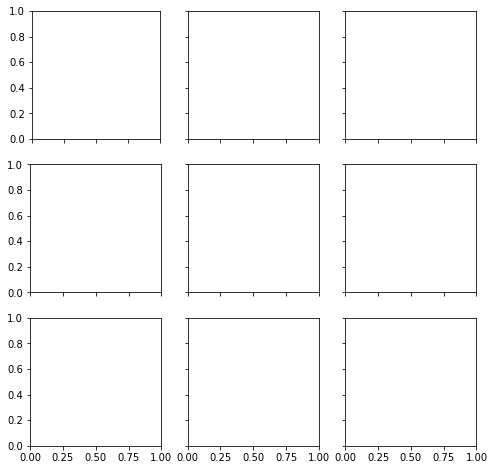

In [21]:
# look at the image
np.random.seed(42)

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(8, 8),
                       sharey=True, sharex=True)

for fig_x in ax.flatten():
    i = np.random.choice(len(dataset), 1)[0]
    im , _, _ = dataset[i]

    fig_x.imshow(im)
    # if img_label is not None:
    #     fig_x.set_title(img_label)
    fig_x.grid(False)

# Model

In [34]:
class FullyConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self._model = nn.Sequential(
             nn.Conv2d(in_channels, 16, 3, 2, self.same_padding(3)),   # 224
             nn.ReLU(),
             nn.BatchNorm2d(16),
             nn.Conv2d(16, 32, 3, 2, self.same_padding(3)),            # 112
             nn.ReLU(),
             nn.BatchNorm2d(32),
             nn.Conv2d(32, 64, 3, 2, self.same_padding(3)),            # 56
             nn.ReLU(),
             nn.BatchNorm2d(64),
             nn.Conv2d(64, 128, 3, 2, self.same_padding(3)),           # 28
             nn.ReLU(),
             nn.BatchNorm2d(128),
             nn.Conv2d(128, 256, 3, 2, self.same_padding(3)),          # 14
             nn.ReLU(),
             nn.AdaptiveAvgPool2d(1),                                  # 7
             nn.Conv2d(256, 512, 1, 1, self.same_padding(1)),          # 1
             nn.ReLU(),
             nn.Dropout(0.2),
             nn.Conv2d(512, out_channels, 1, 1, self.same_padding(1))) # 1 
        
    @staticmethod
    def same_padding(kernel_size):
        return (kernel_size - 1) // 2
    
    def forward(self, X):
        return self._model(X)

In [35]:
model = FullyConv(3, 224*3)

In [36]:
from torch.utils.data import DataLoader
train_loader = DataLoader(dataset, batch_size=1)

In [38]:
for i in train_loader:
    print(i[0].size())
    print(model(i[0]).size())
    break


torch.Size([1, 3, 224, 224])
torch.Size([1, 224, 1, 1])
